#### *Programmation sur Grille de Calcul - Générateurs de Variables Aléatoires*

# TP2 - Lois de probabilité

Nous avons vus dans le TP1 que nous pouvons implémenter des générateurs capables de produire des variables pseudo-aléatoires  indépendantes et identiquement distribuées (iid) sur l'intervale [0, 1].

Cependant, comment peut-on faire pour générer des variables aléatoires de distributions différentes ? C'est ce que l'on va voir dans ce TP.

### Table des matières

* [I - Présentation des différentes méthodes](#presentation)
    * [1 - Méthode d'inversion](#inversion)
    * [2 - Théorèmre Central Limite](#theoreme_central_limite)
    * [3 - Méthode de Box et Muller](#box_muller)
    * [4 - Méthode du rejet](#rejet)
        * [a - Enveloppe de Cauchy](#cauchy)
        * [b - Enveloppe de Laplace](#laplace)
    * [5 - Cas particuliers : Loi de Poisson](#poisson)
* [II - Comparaison des différentes méthodes](#comparaison)

##### Import des bibliothèques

In [2]:
import random
from math import sqrt
from statistics import mean
from typing import List, Callable

import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import erfinv
from scipy.stats import kurtosis, skew
from statsmodels.graphics.gofplots import qqplot_2samples
from math import exp, tan, e, log, pi

##### Fonctions utilitaires

In [7]:
# Implémentation de runif, un générateur de nombres pseudo-aléatoires iid sur l'intervalle [low, high]
def runif(n: int, low: float = 0, high: float = 1) -> np.ndarray:
    return np.array(np.random.uniform(low=low, high=high, size=n))

## I - Présentation des différentes méthodes<a name="presentation"></a>

### 1 - Méthode d'inversion<a name="inversion"></a>

Pour simuler la loi normale, nous allons utiliser la méthode de la loi inverse. Pour ce faire, on dispose de la fonction ``runif()``, un générateur de nombres pseudo-aléatoires iid dans l’intervalle $[0, 1]$ (implémenté ci-dessus).

Pour simuler la loi normale $N(0,1)$, nous devons utiliser l'inverse de sa fonction de répartition qui se calcule avec $erf^-1$ est qui est définie comme suit :

$$\large \blacksquare^{-1} (u) = y = \sqrt{2} erf^{-1} (2u - 1)$$

Voici l'implémentation de la méthode en Python :

In [8]:
def loi_normale_rep_inv(n: int) -> np.ndarray:
    x = runif(n)
    return sqrt(2) * erfinv(2 * x - 1)

In [9]:
# *** fonctions pour plot les distributions ***
def inline_qqplot(func: Callable, lengths: List[int], title: str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))
    
    for index, length in enumerate(lengths):
        x = sm.ProbPlot(func(length))
        y = sm.ProbPlot(func(length))
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_distplot(func: Callable, lengths: List[int], title: str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        sns.distplot(func(length), ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()

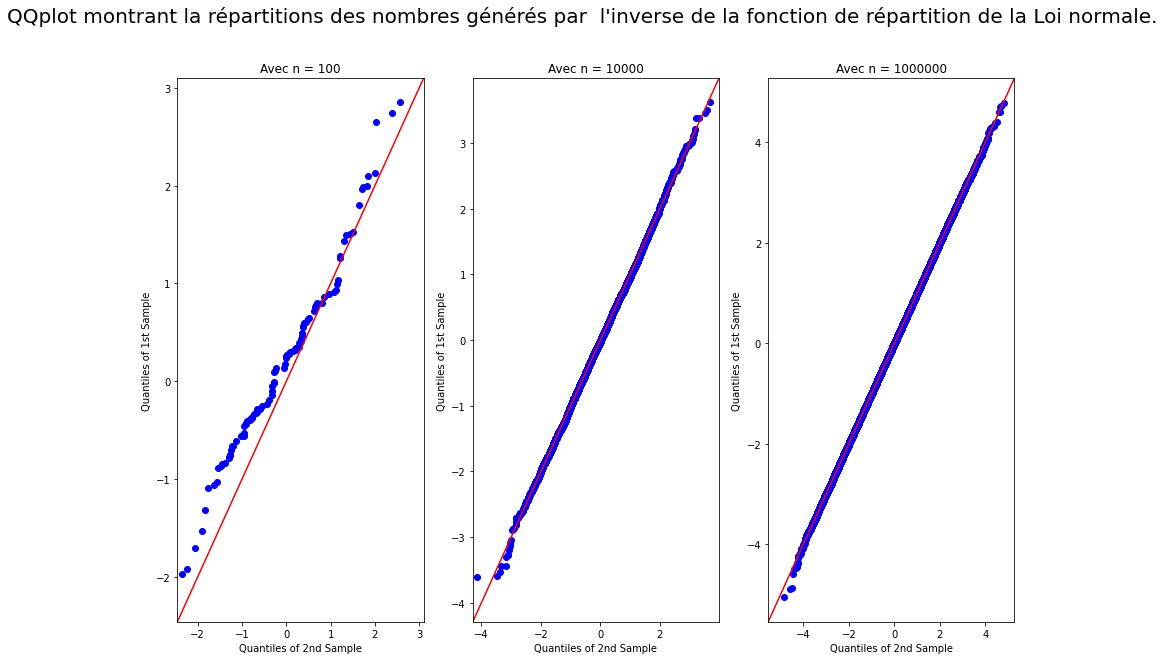

In [10]:
inline_qqplot(loi_normale_rep_inv, [100, 10_000, 1_000_000],
              'QQplot montrant la répartitions des nombres générés par  l\'inverse de la fonction de répartition de la Loi normale.')

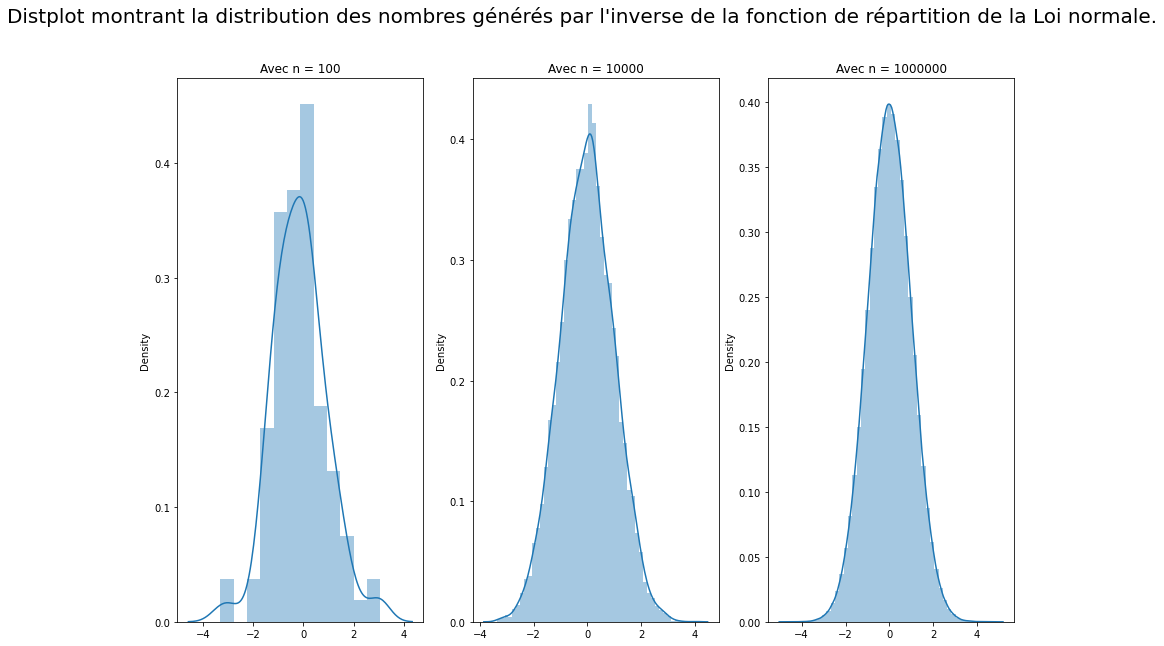

In [11]:
inline_distplot(loi_normale_rep_inv, [100, 10_000, 1_000_000],
                'Distplot montrant la distribution des nombres générés par l\'inverse de la fonction de répartition de la Loi normale.')

### 2 - Théorèmre Central Limite<a name="theoreme_central_limite"></a>

Une application immédiate du Théorème Central Limite est la génération de variables aléatoires normales via une méthode très simple.

Partant de $n$ variables aléatoires $X_i$ de loi uniforme $U_{[0,1]}$, on peut générer une variable
aléatoire $Y$ ayant une loi normale de valeur moyenne $\bar{Y}$ et d'écart-type $\sigma_Y$ par la relation :

$$\large Y = \frac{\sum \limits_{i=1}^n (X_i) - \frac{n} {2}} {\sqrt{\frac{n} {12}}}$$

Voici l'implémentation de la méthode en Python :

In [12]:
def loi_normale_centrale_limite(n: int) -> np.ndarray:
    vect = []
    for i in range(n):
        x = runif(n)
        vect.append((sum(x) - n / 2) / sqrt(n / 12))
    return np.array(vect)

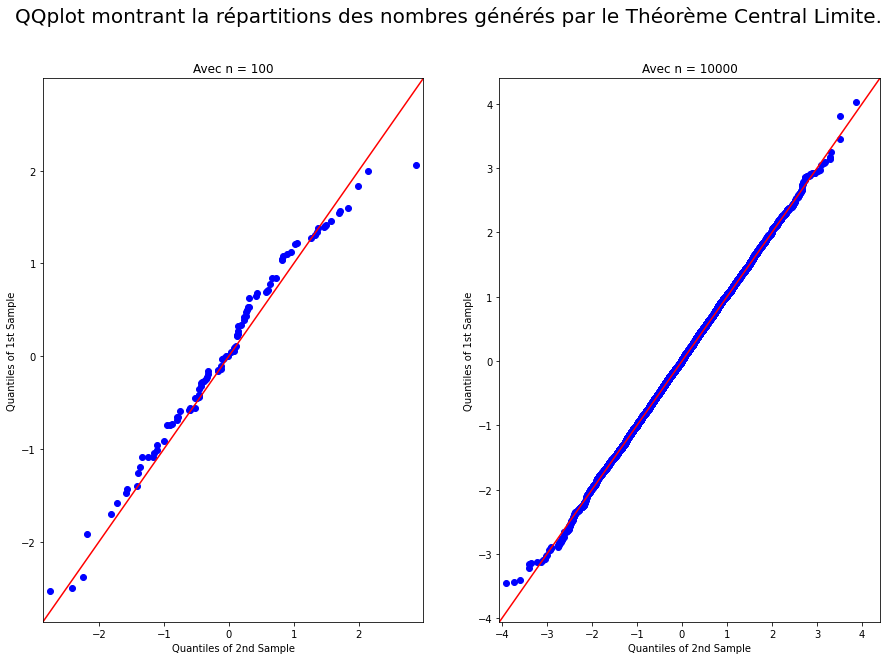

In [13]:
inline_qqplot(loi_normale_centrale_limite, [100, 10_000],
              'QQplot montrant la répartitions des nombres générés par le Théorème Central Limite.')

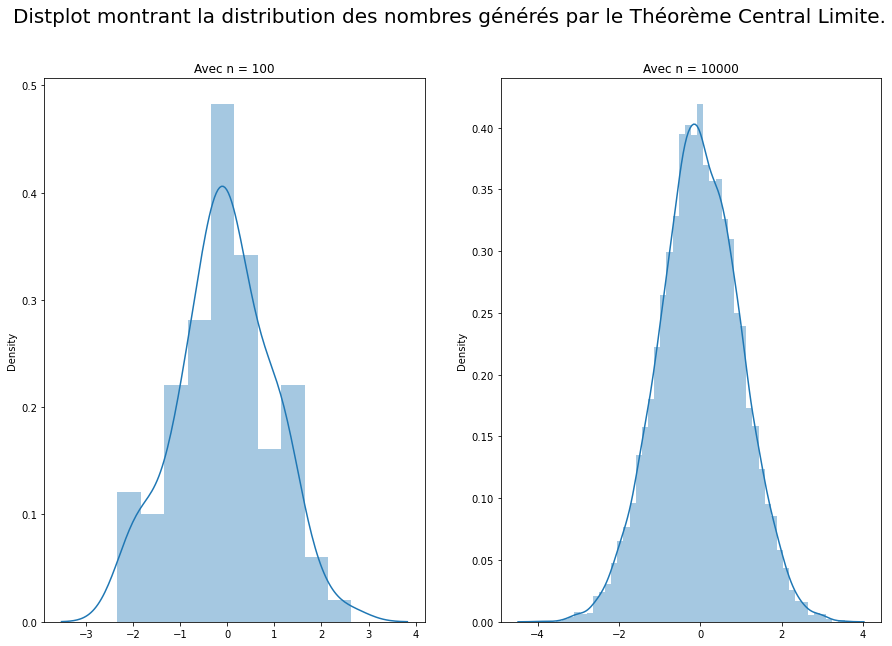

In [14]:
inline_distplot(loi_normale_centrale_limite, [100, 10_000],
                'Distplot montrant la distribution des nombres générés par le Théorème Central Limite.')

### 3 - Méthode de Box et Muller<a name="box_muller"></a>

La
méthode
de
Box
et
Muller
permet
de
générer
un $2
n$-échantillon
de
la
loi $N(0, 1)$ à
partir
d’un
générateur
de
la
loi
uniforme.Si $U1$ et $U2$ sont
indépendantes
de
loi
uniforme
sur $]0, 1[$, alors le couple suivant est formé de variables gaussiennes indépendantes centrées de variance 1:

$$\large
{Y_0} = \sqrt
{-2
ln
{U_1}} \cos({2 \pi
{U_2}}) $$

$$\large
{Y_1} = \sqrt
{-2
ln
{U_1}} \sin({2 \pi
{U_2}}) $$

La
simulation
de
deux
variables
indépendantes
de
loi
uniforme
conduit
à
la
simulation
de
deux
variables
aléatoires
gaussiennes
standard
indépendantes.

Voici
l
'implémentation de la méthode en Python :

In [15]:
def box_muller(n: int):
    x0 = runif(n)
    x1 = runif(n)
    y0 = np.sqrt(-2 * np.log(x0)) * np.cos(2 * pi * x1)
    y1 = np.sqrt(-2 * np.log(x0)) * np.sin(2 * pi * x1)
    return y0, y1

In [16]:
# *** fonctions pour plot la méthode Box & Muller ***
def inline_qqplot_bm(lengths: List[int]) -> None:
    title = 'QQplot montrant la répartitions des nombres générés par la méthode de Box et Muller.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        y0, y1 = box_muller(length)
        x = sm.ProbPlot(y0)
        y = sm.ProbPlot(y1)
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_distplot_bm(lengths: List[int]) -> None:
    title =  'Distplot montrant la distribution des nombres générés par la méthode de Box et Muller.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        y0, y1 = box_muller(length)
        sns.distplot(y0, ax=axes[index])
        sns.distplot(y1, ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.legend(labels=['Y_0', 'Y_1'])
    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()
# ***

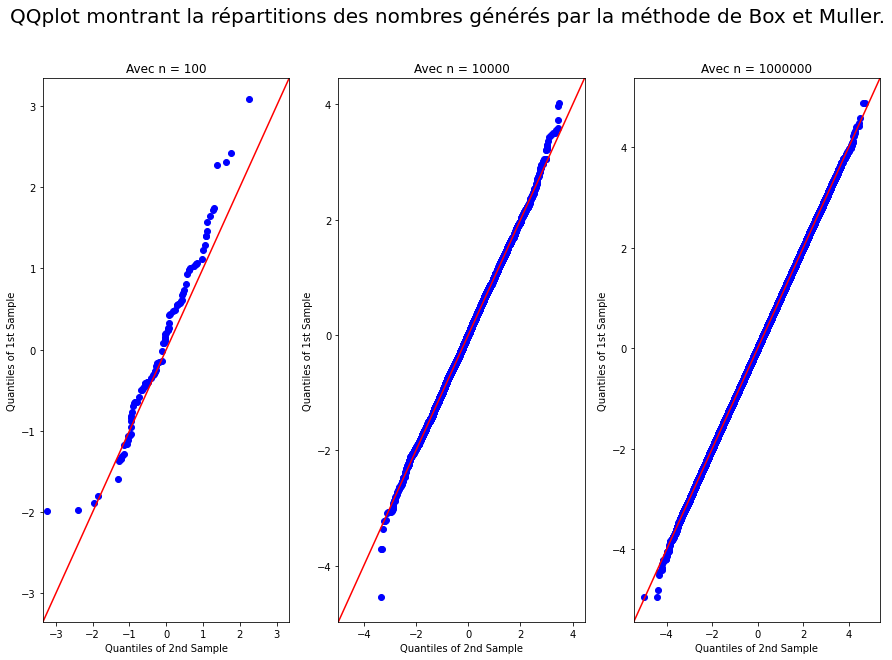

In [17]:
inline_qqplot_bm([100, 10_000, 1_000_000])

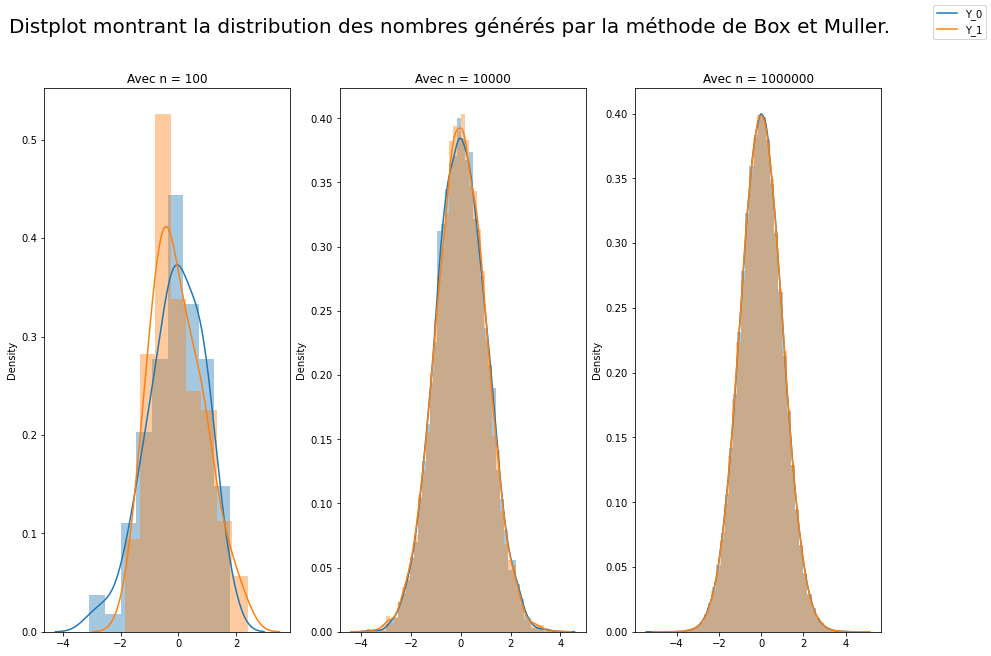

In [19]:
inline_distplot_bm([100, 10_000, 1_000_000])

### 4 - Méthode du rejet<a name="rejet"></a>

La méthode du rejet est utilisée pour engendrer indirectement une variable aléatoire $X$, de densité de probabilité $f$, lorsqu'on ne sait pas simuler directement la loi de densité de probabilité $f$. 

Dans notre cas, on va utiliser les enveloppes de Cauchy et de Laplace, définies ci-après, pour simuler une loi normale.
Ces enveloppes utilisent la fonction de densité gaussienne, implémenté ci-dessous en Python :

In [20]:
def gaussian_density(x):
    a = 1 / (sqrt(2) * pi)
    b = exp(-x * x / 2)
    return a * b

#### a - Enveloppe de Cauchy<a name="cauchy"></a>

$$\large \forall x\in \mathbb{R}, \frac {1} {\sqrt {2 \pi}} e^{\frac{-x^2} {2}} ≤ \sqrt{\frac {2 \pi} {e}}\frac{1} {\pi}  \frac{1} {1 + x^2}$$

...

Voici son implémentation en Python :

In [21]:
def cauchy(n: int) -> np.ndarray:
    res = [0 for _ in range(n)]
    c = sqrt(2 * pi / e)

    for i in range(n):
        u1 = random.uniform(0, 1)
        x = tan(pi * (u1 - 1 / 2))
        u2 = random.uniform(0, 1)
        res[i] = x

        while c * u2 / (pi * (1 + x * x)) > gaussian_density(x):
            u1 = random.uniform(0, 1)
            x = tan(pi * (u1 - 1 / 2))
            u2 = random.uniform(0, 1)
            res[i] = x

    return np.array(res)

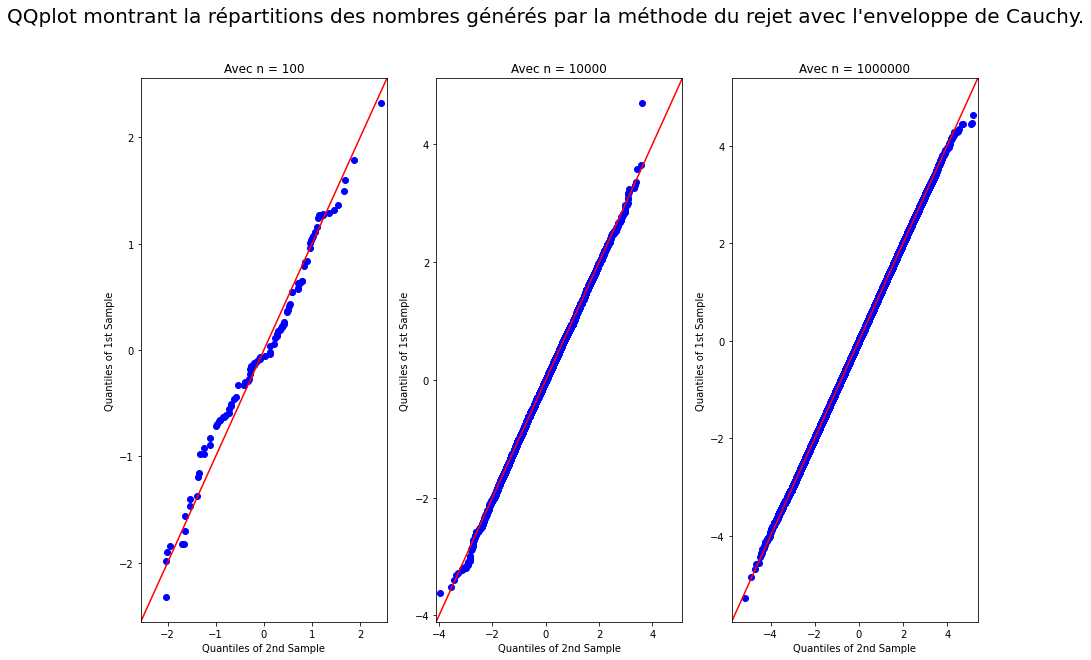

In [22]:
inline_qqplot(cauchy, [100, 10_000, 1_000_000],
              'QQplot montrant la répartitions des nombres générés par la méthode du rejet avec l\'enveloppe de Cauchy.')

KeyboardInterrupt: 

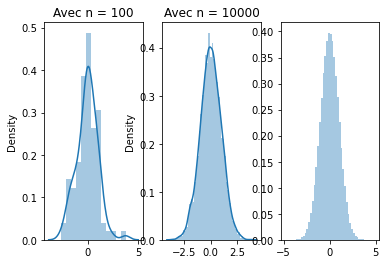

In [25]:
inline_distplot(cauchy, [100, 10_000, 1_000_000],
                'Distplot montrant la distribution des nombres générés par la méthode du rejet avec l\'enveloppe de Cauchy.')

#### b - Enveloppe de Laplace<a name="laplace"></a>

$$\large \forall x\in \mathbb{R}, \frac {1} {\sqrt {2 \pi}} e^{\frac{-x^2} {2}} ≤ 2 \sqrt{\frac {e} {2 \pi}} \frac{1} {2} e^{- |x|}$$

...

Voici son implémentation en Python :

In [ ]:
def laplace(n: int) -> np.ndarray:
    res = [0 for _ in range(n)]
    c = 2 * (sqrt(e / 2 * pi))
    b = 1
    mu = 0

    for i in range(n):
        u1 = random.uniform(0, 1)
        x = mu - b * np.sign(u1 - 0.5) * log(1 - 2 * abs(u1 - 0.5))
        u2 = random.uniform(0, 1)
        res[i] = x

        while c * u2 * 1 / 2 * exp(-abs(x)) > gaussian_density(x):
            u1 = random.uniform(0, 1)
            x = mu - b * np.sign(u1 - 0.5) * log(1 - 2 * abs(u1 - 0.5))
            u2 = random.uniform(0, 1)
            res[i] = x

    return np.array(res)

In [ ]:
inline_qqplot(laplace, [100, 10_000, 1_000_000],
              'QQplot montrant la répartitions des nombres générés par la méthode du rejet avec l\'enveloppe de Laplace.')

In [ ]:
inline_distplot(laplace, [100, 10_000, 1_000_000],
                'Distplot montrant la distribution des nombres générés par la méthode du rejet avec l\'enveloppe de Laplace.')

### 5 - Cas particuliers : Loi de Poisson<a name="poisson"></a>

...

Voici son implémentation en Python :

In [32]:
def poisson(lmbd: int, n: int) -> np.ndarray:
    if(lmbd <= 0):
        raise ValueError('Lambda should be stricly positi')
    
    dist = np.zeros(n)  # init

    for i in range(n):

        exp_sum = 0
        counter = -1

        while exp_sum < 1:
            exp_sum += -(1 / lmbd) * np.log(random.uniform(0, 1))
            counter += 1

        dist[i] = counter

    return dist

In [28]:
# *** fonctions pour plot la loi de poisson ***
def inline_qqplot_poisson(lmbd: int, lengths: List[int]) -> None:
    title = f'QQplot montrant la répartitions des nombres générés en approximant de la loi de Poisson (λ = {lmbd})'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        x = sm.ProbPlot(poisson(lmbd, length))
        y = sm.ProbPlot(poisson(lmbd, length))
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_histplot_poisson(lmbd: int, lengths: List[int]) -> None:
    title = f'Histogrammes montrant la distribution des nombres générés en approximant de la loi de Poisson (λ = {lmbd})'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))
    
    for index, length in enumerate(lengths):
        sns.histplot(poisson(lmbd, length), ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')
        
    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()
# ***

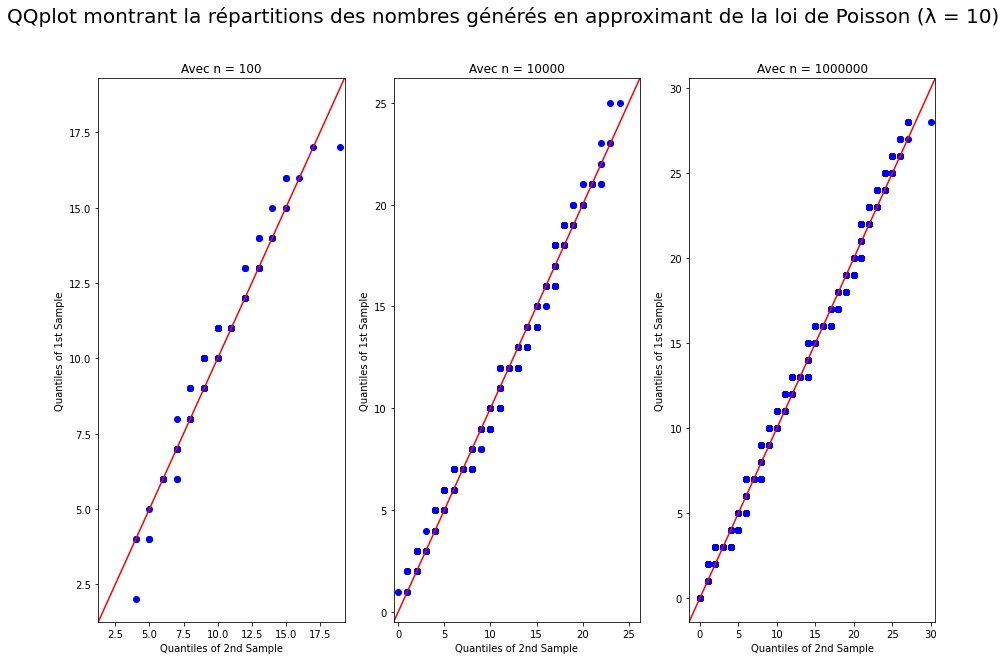

In [29]:
inline_qqplot_poisson(10, [100, 10_000])

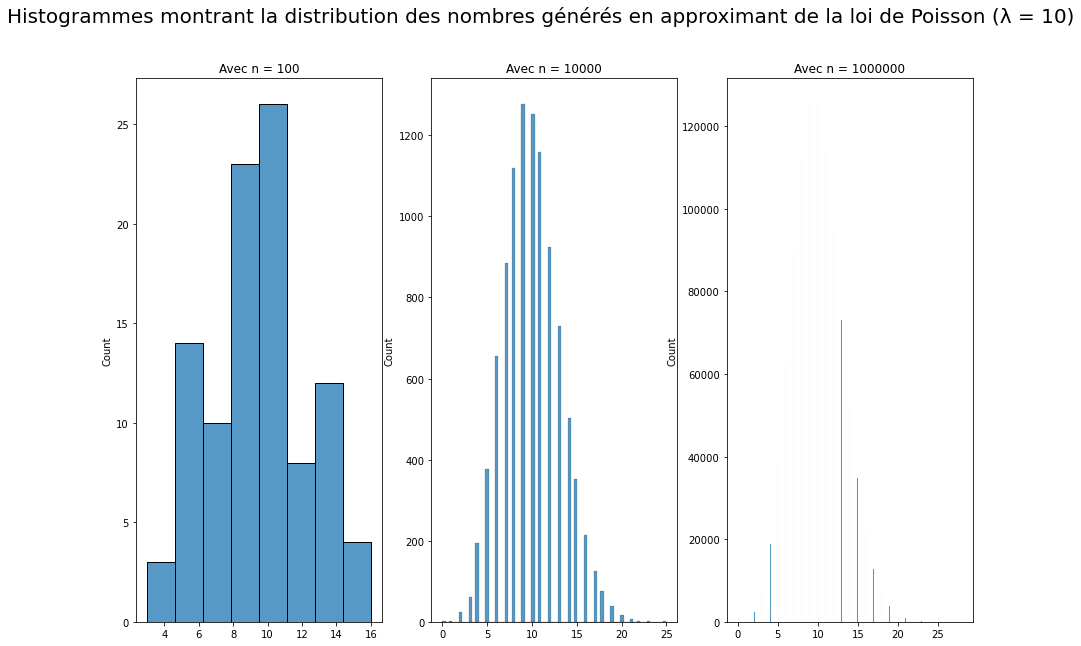

In [31]:
inline_histplot_poisson(10, [100, 10_000])

lambda = la moyenne et la variance
kurtosis = 1/lambda

In [ ]:
n = 10_000
lmdb = 10
dist = poisson(lmdb, n)

data = {'Mean value': mean(dist),
        'Quartile 25%': np.percentile(dist, 25),
        'Quartile 50% ': np.percentile(dist, 50),
        'Quartile 75%': np.percentile(dist, 75),
        'Variance': np.var(dist),
        'Kurtosis (normalised)': kurtosis(dist),
        'Skewness': skew(dist)}

pd.DataFrame.from_dict(data, orient='index', columns=['Poisson'])

## II - Comparaison des différentes méthodes<a name="comparaison"></a>

In [ ]:
NAMES = ['Loi Normale Inverse', 'Loi Normale Centrale Limite', 'Box et Muller (Y_0)', 'Box et Muller (Y_1)', 'Enveloppe de Cauchy',
         'Enveloppe de Laplace']
n = 10_000
y0, y1 = box_muller(n)
distributions = [loi_normale_rep_inv(n), loi_normale_centrale_limite(n), y0, y1, cauchy(n), laplace(n)]

data = {'Mean value': [mean(sublist) for sublist in distributions],
        'Quartile 25%': [np.percentile(sublist, 25) for sublist in distributions],
        'Quartile 50%': [np.percentile(sublist, 50) for sublist in distributions],
        'Quartile 75%': [np.percentile(sublist, 75) for sublist in distributions],
        'Variance': [np.var(sublist) for sublist in distributions],
        'Kurtosis (normalised)': [kurtosis(sublist) for sublist in distributions],
        'Skewness': [skew(sublist) for sublist in distributions]}

pd.DataFrame.from_dict(data, orient='index', columns=NAMES)